In [1]:
import pandas as pd
from igraph import *

In [2]:
data = pd.read_csv("FAOSTAT_data.csv")

In [3]:
data.head()

,Domain Code,Domain,Reporter Country Code (FAO),Reporter Countries,Partner Country Code (FAO),Partner Countries,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag,Flag Description
0,FT,Forestry Trade Flows,2,Afghanistan,68,France,5922,Export Value,1633,"Sawnwood, non-coniferous all",2017,2017,1000 US$,37,NaN,Official data
1,FT,Forestry Trade Flows,2,Afghanistan,165,Pakistan,5922,Export Value,1671,Newsprint,2017,2017,1000 US$,2,NaN,Official data
2,FT,Forestry Trade Flows,3,Albania,11,Austria,5922,Export Value,1633,"Sawnwood, non-coniferous all",2017,2017,1000 US$,29,NaN,Official data
3,FT,Forestry Trade Flows,3,Albania,33,Canada,5922,Export Value,1619,Wood chips and particles,2017,2017,1000 US$,0,NaN,Official data
4,FT,Forestry Trade Flows,3,Albania,68,France,5922,Export Value,1632,"Sawnwood, coniferous",2017,2017,1000 US$,13,NaN,Official data


In [4]:
# remove non-empty values in Flag column
data = data[data["Flag"].isna()]

In [5]:
# is the unit the same?
data["Unit"].unique()

array(['1000 US$'], dtype=object)

## 1.

In [6]:
def create_export_graph(graph_df):
    G_2017 = Graph(directed=True)

    # create nodes
    countries = graph_df["Reporter Countries"].tolist() + graph_df["Partner Countries"].tolist()
    countries = set(countries)
    G_2017.add_vertices(countries)
    G_2017.vs['label'] = list(countries)
    countries_dict = {}
    for i, c in enumerate(countries):
        countries_dict[c] = i

    # create vertices
    edges = []
    weights = []
    for _, row in graph_df.iterrows():
        edges.append((countries_dict[row["Reporter Countries"]], countries_dict[row["Partner Countries"]]))
        weights.append(row["Value"])

    G_2017.add_edges(edges)
    G_2017.es['weight'] = weights
    G_2017.es['label'] = weights
    
    return G_2017

In [7]:
small_data = data[data["Reporter Countries"].isin(["China", "France", "Netherlands", "Germany"])]
small_data = small_data[small_data["Partner Countries"].isin(["United Kingdom", "France", "Netherlands", "Germany"])]

graph_df = small_data[["Reporter Countries", "Partner Countries", "Value"]].groupby(["Reporter Countries", "Partner Countries"]).sum().reset_index()
G_2017 = create_export_graph(graph_df)

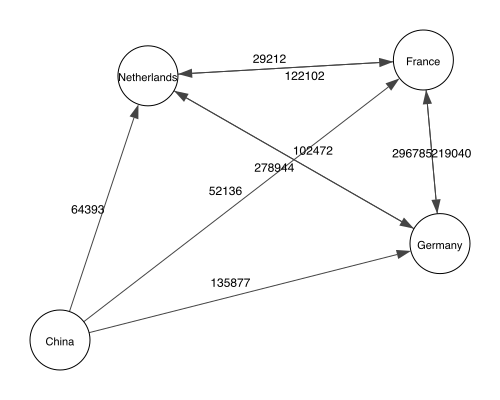

In [43]:
visual_style = {}

out_name = "graph_1.png"

# Set bbox and margin
visual_style["bbox"] = (500,400)
visual_style["margin"] = 60
visual_style["vertex_color"] = 'white'
visual_style["vertex_size"] = 60
visual_style["vertex_label_size"] = 11
visual_style["edge_curved"] = False
my_layout = G_2017.layout_lgl()
visual_style["layout"] = my_layout
plot(G_2017, out_name, **visual_style)

## 2.

We removed also values of partner countries with "Unspecified Area" (probably "Total FAO" got renamed). 

In [75]:
def create_g_top(country_name):
    # get top export partners
    
    all_data = data[["Reporter Countries", "Partner Countries", "Value"]].groupby(["Reporter Countries", "Partner Countries"]).sum().reset_index()
    country_data = all_data[all_data["Reporter Countries"] == country_name]
    
    relevant_countries = country_data.loc[country_data["Value"].nlargest(3).index]["Partner Countries"].tolist()
    relevant_countries.append(country_name)
    country_data
    
    # create relevant dataframe
    relevant_data = all_data[all_data["Reporter Countries"].isin(relevant_countries)]
    relevant_data = relevant_data[relevant_data["Partner Countries"].isin(relevant_countries)]
    
    # use the method from 1. to create a graph
    g_top = create_export_graph(relevant_data)
    
    return g_top
    

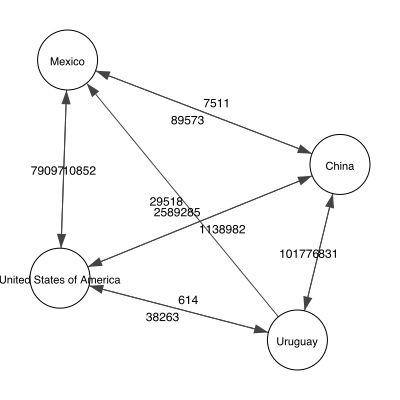

In [80]:
G_top = create_g_top("Uruguay")

visual_style = {}

out_name = "graph_2.png"

# Set bbox and margin
visual_style["bbox"] = (400,400)
visual_style["margin"] = 60
visual_style["vertex_color"] = 'white'
visual_style["vertex_size"] = 60
visual_style["vertex_label_size"] = 11
visual_style["edge_curved"] = False
my_layout = G_top.layout_lgl()
visual_style["layout"] = my_layout
plot(G_top, out_name, **visual_style)

## 3.

In [155]:
def get_country_type(country_name):
    g = create_export_graph(data)
    
    # get node of the country
    country_node = g.vs.find(label=country_name)
    
    # get outgoing edges weights
    out_edges = g.incident(country_node, mode='out')
    
    sum_out_edges = 0
    for e in out_edges:
        sum_out_edges += g.es[e]["weight"]
        
    # get ingoing edges weights
    in_edges = g.incident(country_node, mode='in')
    
    sum_in_edges = 0
    for e in in_edges:
        sum_in_edges += g.es[e]["weight"]
        
    if sum_out_edges > sum_in_edges:
        return f"{country_name} is a net exporter, its export value: {sum_out_edges}"
        
    else:
        return f"{country_name} is a net importer, its import value: {sum_in_edges}"
        
    

In [156]:
get_country_type("Germany")

'Germany is a net importer, its import value: 3785835'

In [153]:
all_data_1 = data.copy()
all_data_1 = all_data_1[all_data_1["Reporter Countries"].isin(["Mexico", "United States of America", "China", "Uruguay"])]
all_data_1 = all_data_1[all_data_1["Partner Countries"].isin(["Mexico", "United States of America", "China", "Uruguay"])]

all_data_1 = all_data_1[["Reporter Countries", "Partner Countries", "Value"]].groupby(["Reporter Countries", "Partner Countries"]).sum().reset_index()
all_data_1

,Reporter Countries,Partner Countries,Value
0,China,Mexico,89573
1,China,United States of America,1138982
2,China,Uruguay,831
3,Mexico,China,7511
4,Mexico,United States of America,10852
5,United States of America,China,2589285
6,United States of America,Mexico,79097
7,United States of America,Uruguay,614
8,Uruguay,China,101776
9,Uruguay,Mexico,29518


In [ ]:
data[data]

In [11]:
create_g_top("Uruguay")

   Reporter Countries         Partner Countries   Value
8             Uruguay                     China  101776
40            Uruguay  United States of America   38263
22            Uruguay                    Mexico   29518


In [12]:
data[data["Reporter Countries"] == "Uruguay"][["Reporter Countries", "Partner Countries", "Value"]].groupby(["Reporter Countries", "Partner Countries"]).sum()

Value
Reporter Countries Partner Countries                                         
Uruguay            Argentina                                             2014
                   Australia                                               43
                   Bangladesh                                              41
                   Belgium                                               1480
                   Bolivia (Plurinational State of)                       313
                   Brazil                                                 241
                   Canada                                                 285
                   Chile                                                 3673
                   China                                               101776
                   Cuba                                                    53
                   Denmark                                                356
                   France                                                3090
                   Germany                                                318
                   India                                                  763
                   Indonesia                                             3128
                   Ireland                                                810
                   Italy                                                 1308
                   Japan                                                   55
                   Kuwait                                                  52
                   Lithuania                                               76
                   Malaysia                                                14
                   Mauritius                                              138
                   Mexico                                               29518
                   Morocco                                                245
                   Netherlands                                           6175
                   New Zealand                                             21
                   Paraguay                                               236
                   Peru                                                    54
                   Philippines                                             96
                   Poland                                                  96
                   Portugal                                                 1
                   Republic of Korea                                     6650
                   Singapore                                               35
                   South Africa                                          4171
                   Spain                                                  186
                   Sri Lanka                                                4
                   Sweden                                                   8
                   Thailand                                               109
                   Trinidad and Tobago                                     30
                   United Kingdom of Great Britain and Northern Ir...    8094
                   United States of America                             38263
                   Viet Nam                                             10876

In [13]:
data[data["Reporter Countries"] == "Uruguay"][["Reporter Countries", "Partner Countries", "Value"]].groupby(["Reporter Countries", "Partner Countries"]).sum().reset_index()["Value"].nlargest(5)

8     101776
40     38263
22     29518
41     10876
39      8094
Name: Value, dtype: int64

In [14]:
!pip install pycairo

zsh:1: command not found: pip


In [15]:
graph_df

,Reporter Countries,Partner Countries,Value
0,China,France,52136
1,China,Germany,135877
2,China,Netherlands,64393
3,France,Germany,219040
4,France,Netherlands,122102
5,Germany,France,296785
6,Germany,Netherlands,278944
7,Netherlands,France,29212
8,Netherlands,Germany,102472


In [16]:
G_2017.get_nids

AttributeError: 'Graph' object has no attribute 'get_nids'